# Cluster Trait GWAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cna, pickle, os, pp 
from matplotlib import lines
import scipy.stats as st
from matplotlib.patches import ConnectionPatch

res_folder="/data/srlab/lrumker/MCSC_Project/cna-qtl/cluster_gwas/"
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"

In [2]:
# From Okabe & Ito, "colorblind-friendly" palette 
from matplotlib.colors import LinearSegmentedColormap
color_dict = {'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73', 
              'yellow': '#F0E442', 'purple': '#CC79A7', 'oceanblue': '#0072B2', 
              'vermillion': '#E63d00'} # O&I use '#D55E00'

## Confirm no highly correlated traits

In [3]:
traits = pd.read_table(res_folder+"cluster_traits.tsv")
traits.set_index('IID', inplace = True, drop = True)
traits.drop(columns=['FID'], inplace = True)
n_traits = traits.shape[1]
np.sum(np.sum(traits.corr()**2>0.7))-traits.shape[1]

0

## GWAS results

In [4]:
# Report significance thresholds
for gwas_type in ['T', 'B', 'NK', 'Myeloid', 'allcells']:
    shared_type = [traits.columns[i].split("_frac_")[1] == gwas_type \
                   for i in np.arange(traits.shape[1])]
    n_traits = np.sum(shared_type)
    gw_sig = 5e-8 / n_traits
    print(str(n_traits)+" traits in the "+gwas_type+" GWAS, so using a threshold of "+str(gw_sig))

10 traits in the T GWAS, so using a threshold of 5e-09
3 traits in the B GWAS, so using a threshold of 1.6666666666666667e-08
1 traits in the NK GWAS, so using a threshold of 5e-08
3 traits in the Myeloid GWAS, so using a threshold of 1.6666666666666667e-08
11 traits in the allcells GWAS, so using a threshold of 4.545454545454545e-09


In [5]:
# SNPs that pass genome-wide significance
loci = pd.DataFrame({})
for i_trait in np.arange(0, 25):
    trait_name=traits.columns[i_trait]
    print(trait_name)
    
    shared_type = [traits.columns[i].split("_frac_")[1] == trait_name.split("_frac_")[1] \
                   for i in np.arange(traits.shape[1])]
    n_traits = np.sum(shared_type)
    gw_sig = 5e-8 / n_traits
    
    res = pd.read_table(res_folder+"gwas_res/T"+str(i_trait+1)+".assoc.linear", delim_whitespace=True)
    
    if np.min(res.P)<gw_sig:
        print(res.loc[res.P<gw_sig,['CHR', 'SNP', 'P']])
        res = res.loc[res.P<gw_sig,:]
        for sel_chr in res.CHR.value_counts().index:
            new = res.loc[res.CHR==sel_chr,:].reset_index()
            new = new.iloc[[np.where(new.P==np.min(new.P))[0][0]]]
            new['Trait'] = np.repeat(trait_name, new.shape[0])
            loci = pd.concat([loci, new])

CD4 TCM_frac_T
CD8 TEM_frac_T
CD4 Naive_frac_T
CD8 Naive_frac_T
CD8 TCM_frac_T
gdT_frac_T
CD4 CTL_frac_T
CD4 TEM_frac_T
Treg_frac_T
MAIT_frac_T
B naive_frac_B
B intermediate_frac_B
B memory_frac_B
CD14 Mono_frac_Myeloid
CD16 Mono_frac_Myeloid
         CHR                      SNP             P
5400234   15          15:80250863:A:G  1.422000e-08
5400240   15          15:80255209:C:T  1.601000e-08
5400246   15          15:80259074:G:A  2.045000e-09
5400247   15  15:80259159:AGCAGGAAG:A  2.045000e-09
5400249   15      15:80259955:TGTAA:T  1.355000e-09
5400250   15          15:80259964:C:T  2.662000e-09
5400251   15          15:80260014:T:C  2.111000e-09
5400252   15          15:80260273:A:T  1.790000e-09
5400253   15          15:80260274:A:T  2.258000e-09
5400254   15          15:80260275:A:T  1.133000e-09
5400255   15          15:80260554:G:A  2.662000e-09
5400256   15          15:80260872:G:A  1.355000e-09
5400257   15          15:80263217:C:T  1.080000e-09
5400258   15          15:8026

In [6]:
loci = loci.loc[:,['Trait','CHR', 'BP', 'A1', 'P', 'BETA']]
loci.columns = ['Trait', 'CHR', 'BP', 'Effect Allele', 'P', 'BETA']
loci
loci = loci.iloc[[0,3,1,2,4],:]
with open('/data/srlab/lrumker/MCSC_Project/cna-qtl/tables/supptable.cluster_gwas.tex','w') as tf:
    tf.write(loci.to_latex(index = False))

## Manhattan plots

14


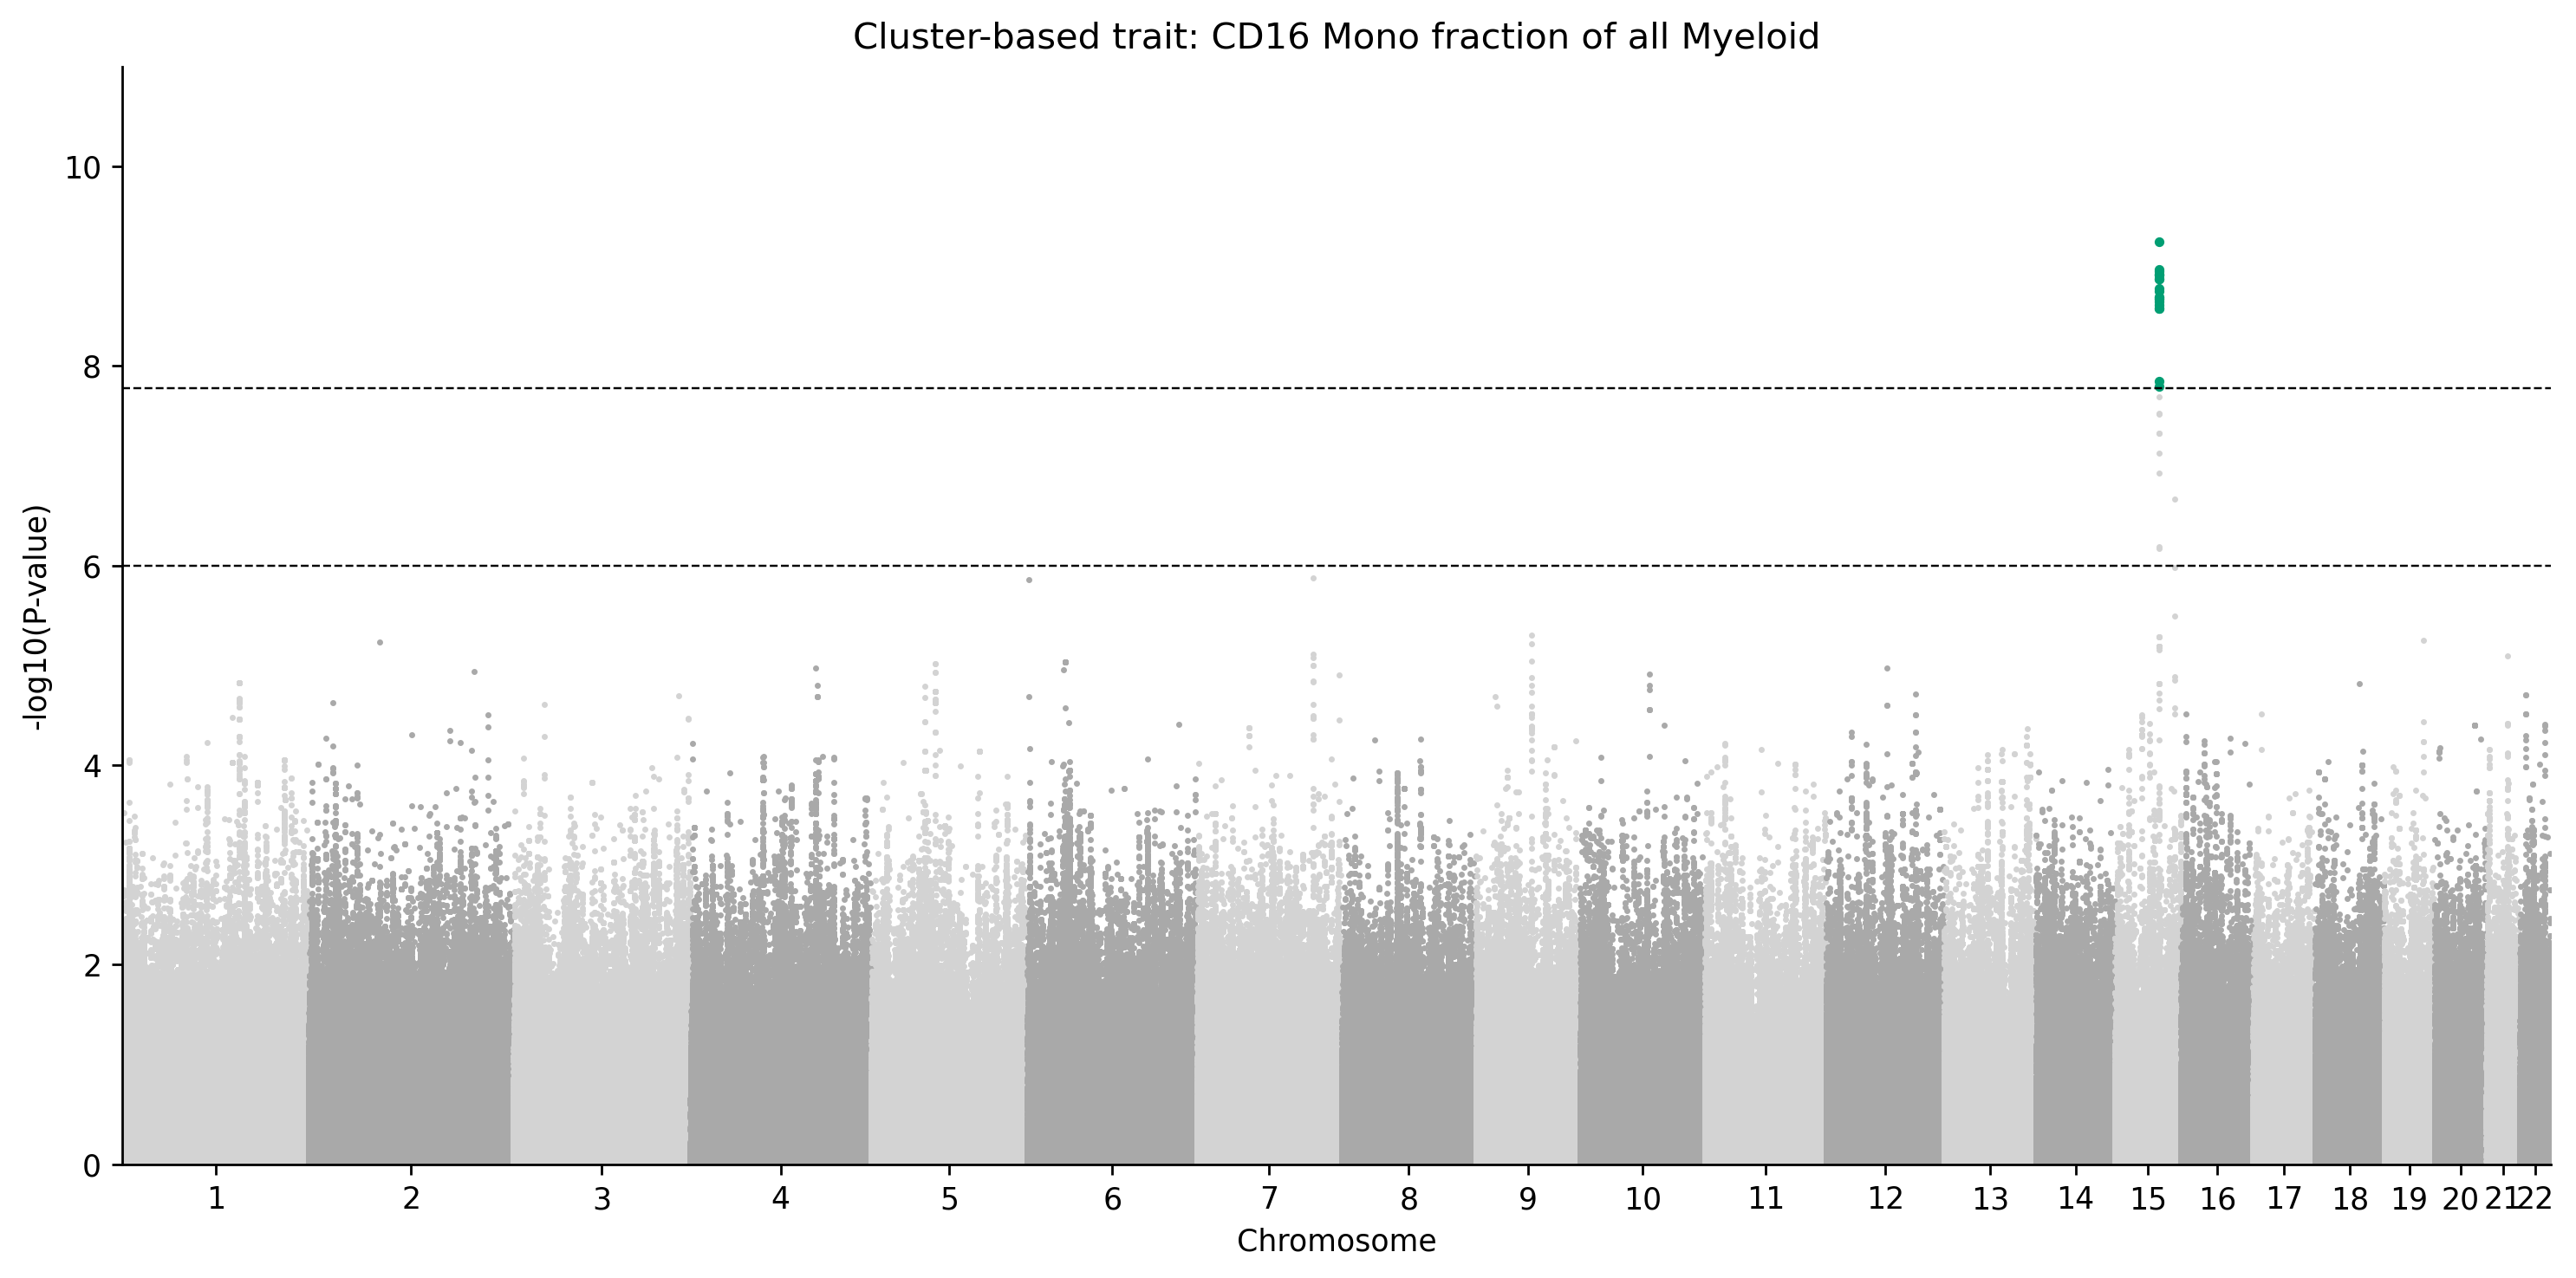

16


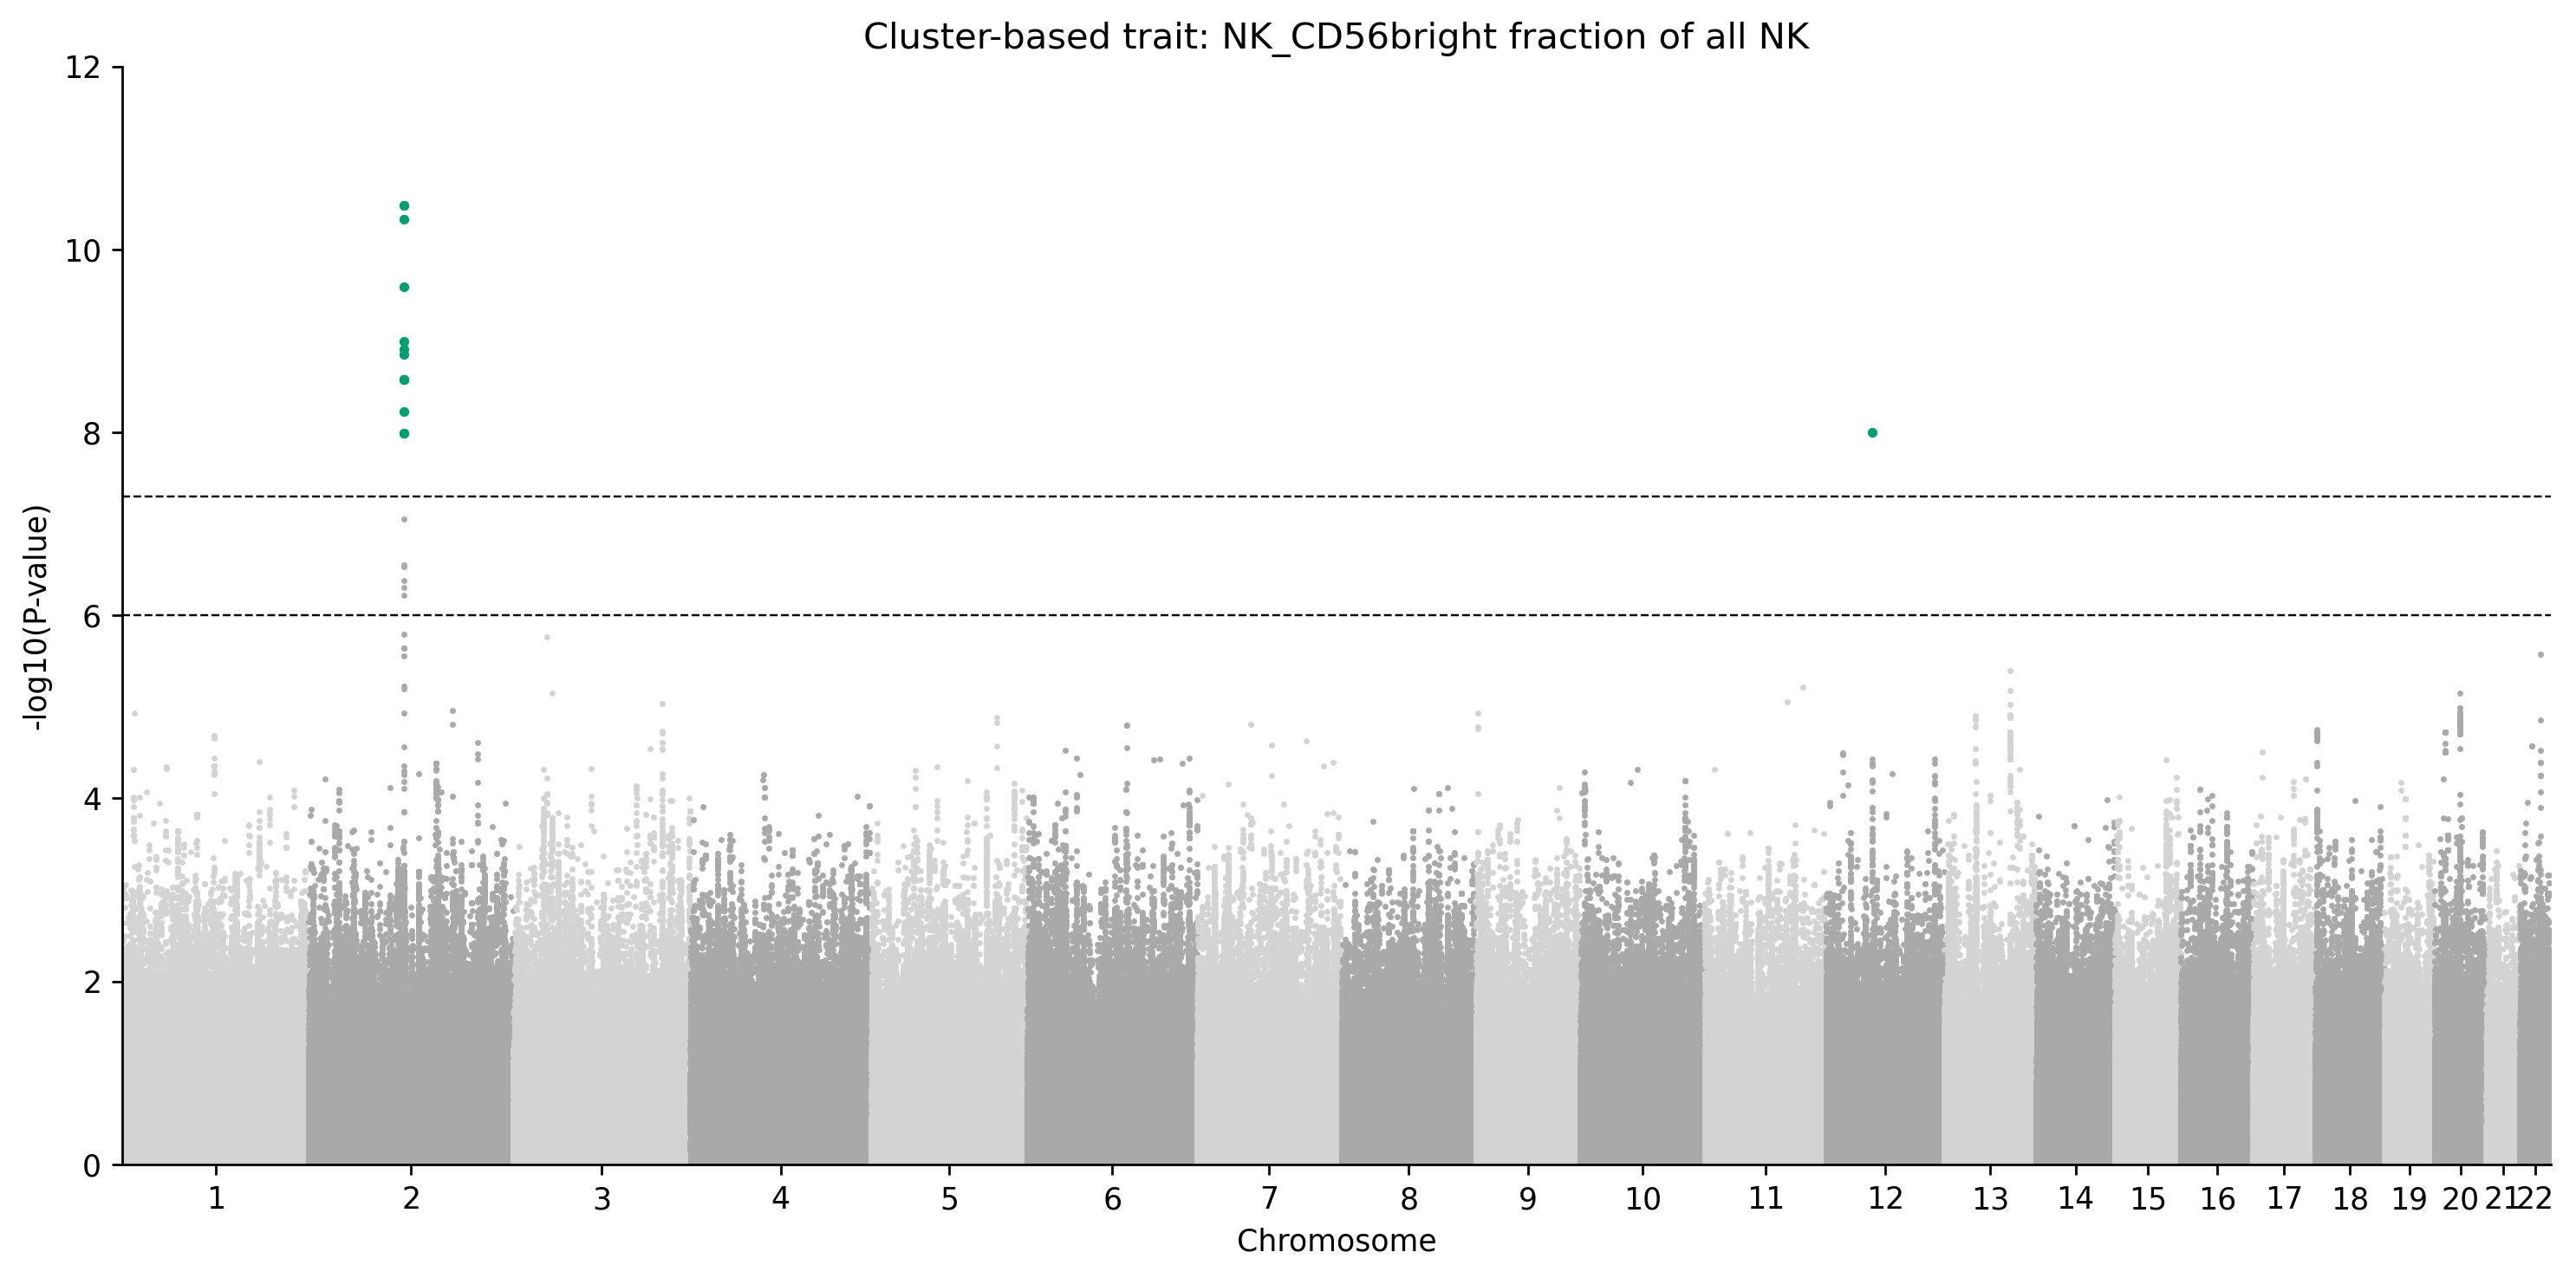

In [7]:
for i_trait in [14, 16]:
    print(i_trait)
    trait_filename="_".join(traits.columns[i_trait].split(" "))
    split_name = traits.columns[i_trait].split("_frac_")
    if split_name[1]=="allcells":
        trait_printname=split_name[0]+" fraction of all cells"
    else:
        trait_printname=" fraction of all ".join(split_name)
    
    # Load gwas results
    res = pd.read_csv(res_folder+"gwas_res/T"+str(i_trait+1)+".assoc.linear", 
                         delim_whitespace=True)
        
    res['log10p'] = -np.log10(res['P'])
    res['ind'] = range(res.shape[0])
    res_grouped = res.groupby(('CHR'))
    res = res.astype({'CHR':'string'})

    if i_trait==14: # myeloid GWAS
        gw_sig = 1.67e-8
    if i_trait==16: # NK GWAS
        gw_sig = 5e-8
    
    # Generate plot
    fig = plt.figure(figsize=(12, 6), dpi = 250) # Set the figure size
    ax = fig.add_subplot(111)
    colors = ['lightgrey', 'darkgrey']
    x_labels = []
    x_labels_pos = []
    for num, (name, group) in enumerate(res_grouped):
        group.plot(kind='scatter', x='ind', y='log10p',color=colors[num % len(colors)], ax=ax, s=1, rasterized = True)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)

    res.loc[res.P.values < gw_sig,:].plot(kind='scatter', x='ind', y='log10p',
       color=color_dict['green'], ax=ax, s=5, rasterized = True)

    # set axis limits
    ax.set_xlim([0, len(res)])
    ax.set_ylim([0, np.max([10,np.ceil(np.max(res.log10p))+1])])

    # x axis label
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(P-value)')

    # Genomewide sig threshold
    ax.axhline(y=-np.log10(gw_sig), linestyle="--", color = "black", lw=0.7)
    ax.axhline(y=-np.log10(1e-06), linestyle="--", color = "black", lw=0.7)
    
    # remove top / right spines
    ax.spines[['right', 'top']].set_visible(False)

    plt.title("Cluster-based trait: "+trait_printname)
    plt.tight_layout()
    plt.savefig(fig_dir+"cluster_gwas/gwas_"+trait_filename+".png", dpi = 300, transparent=True)
    plt.show()